In this script, I am going to just output the rasters to do the analysis in a separate script.

## Import packages

In [2]:
from __future__ import division

#import affine
#import contextily
import fiona
import geopandas as gpd
import matplotlib as mpl
from   matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from   matplotlib.patches import Patch
from   matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from   rasterio.crs import CRS
from   rasterio.enums import Resampling
from   rasterio.features import rasterize
import rasterio.mask
from   rasterio.plot import show
from   rasterio.transform import from_bounds
from   rasterio import shutil as rio_shutil
from   rasterio.vrt import WarpedVRT
from   rasterio import Affine

from   requests import Request
from   scipy.interpolate import interpn
from   scipy.interpolate import griddata
from   scipy import stats
import sys

import shapely
from   shapely.geometry import Point
from   shapely.geometry import mapping, Polygon
import string
from   owslib.wcs import WebCoverageService

%matplotlib inline

In [3]:
figuredirectory = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\paper_figures'

## Define functions

In [4]:
def get_raster(raster_fname):

    wt_rstr = rasterio.open(raster_fname)

    with rasterio.open(raster_fname) as grd:
        wt_ar = grd.read()[0,:,:]
        wt_meta = grd.profile   
        wt_bounds = grd.bounds
        wt_res = grd.res

    mask = np.zeros_like(wt_ar)
    nrows,ncols = np.shape(mask)

    return wt_rstr, wt_ar, wt_meta, wt_bounds, wt_res, mask, nrows, ncols

#--------------------------------------------------------------------------------------------------------------------------
def reproject_raster(in_path, out_path, dst_crs):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = rasterio.warp.calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return(out_path)

#--------------------------------------------------------------------------------------------------------------------------
def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):
    
    ## Get the centroid locations for every pixel
    cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
    xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
    X_array = np.array(xs)
    Y_array = np.array(ys)
    
    ## Calculate the distance from each well to every cell in order to get the well indexes
    well_ixs = []

    for ix in df_head_at_wells_from_rstr.index:

        e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
        n_well = wells_df_2_gdf.loc[ix, "mga_northing"]

        c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
        well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))
    
    return well_ixs

#--------------------------------------------------------------------------------------------------------------------------
def get_raster_head_per_well(well_ixs, wt_ar_utm): 
    
    raster_head_vals = []

    for ix in well_ixs:
        raster_head_vals.append(wt_ar_utm[ix[0], ix[1]])
        
    return raster_head_vals

## Projection and colour set ups

In [5]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32754')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

wt_cmap = "rainbow"
dem_cmap = "terrain"

## Check files in folder

In [6]:
fldr = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters'

hand_output_raster_list = []
for file in os.listdir(fldr):
    if file.endswith(".tif"):
        hand_output_raster_list.append(file)
    else:
        pass
    
print(hand_output_raster_list)
print(len(hand_output_raster_list))

['ref_001_raster.tif', 'ref_002_raster.tif', 'ref_003_raster.tif', 'ref_004_raster.tif', 'ref_005_raster.tif', 'ref_008_raster.tif', 'ref_009_raster.tif', 'ref_012b_raster.tif', 'ref_012_raster.tif', 'ref_014_raster.tif', 'ref_016_raster.tif', 'ref_017_raster.tif', 'ref_021_raster.tif', 'ref_024_raster.tif', 'ref_025_raster.tif', 'ref_026_raster.tif', 'ref_028_raster.tif', 'ref_029_raster.tif', 'ref_030_raster.tif', 'ref_031_raster.tif', 'ref_032_raster.tif', 'ref_033_raster.tif', 'ref_034_raster.tif', 'ref_036_raster.tif', 'ref_037_raster.tif', 'ref_043_raster.tif', 'ref_044_raster.tif', 'ref_045_raster.tif', 'ref_047_raster.tif', 'ref_048_raster.tif', 'ref_049_raster.tif', 'ref_050_raster.tif', 'ref_AAA3_raster.tif', 'ref_AGC_001_raster.tif', 'ref_AGC_011_raster.tif', 'ref_AGC_014_raster.tif', 'ref_AGC_015_raster.tif', 'ref_AGC_016_raster.tif', 'ref_AGC_018_raster.tif', 'ref_BARD_raster.tif', 'ref_BB01_raster.tif', 'ref_C01_raster.tif', 'ref_DEW_01_raster.tif', 'ref_DEW_02_raster.tif

# JUST TEMPORARILY REMOVING A FEW BECAUSE I HAVEN'T MADE THEM AS UTM

In [7]:
#hand_output_raster_list = hand_output_raster_list[:-3]
#print(hand_output_raster_list)

## Shape file of study area extent

In [8]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 
                                 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)
# Change to utm
study_area_shp_utm = study_area_shp.to_crs(utm)

## Shape files of hand-drawn extent

In [17]:
raster_extent_loc = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data\raster_shapes'

raster_extent_shp_list = []
raster_extent_nm_list = []
for file in os.listdir(raster_extent_loc):
    if file.endswith(".shp"):
        print(file)
        shp = gpd.read_file(os.path.join(raster_extent_loc, file))
        shp = shp.to_crs(utm)
        raster_extent_shp_list.append(shp)
        raster_extent_nm_list.append(file[10:-4])

    else:
        pass
    
#print(raster_extent_shp_list)
print(raster_extent_nm_list)

studyarea_009.shp
studyarea_012.shp
studyarea_012b.shp
studyarea_021.shp
studyarea_029.shp
studyarea_030.shp
studyarea_031.shp
studyarea_033.shp
studyarea_037.shp
studyarea_043.shp
studyarea_AGC_014.shp
studyarea_BB01.shp
studyarea_C01.shp
studyarea_EMM01.shp
studyarea_GH01.shp
studyarea_J5897.shp
studyarea_NB.shp
studyarea_RS01.shp
studyarea_u1949.shp
studyarea_UWA_003.shp
studyarea_U_1949.shp
['009', '012', '012b', '021', '029', '030', '031', '033', '037', '043', 'AGC_014', 'BB01', 'C01', 'EMM01', 'GH01', 'J5897', 'NB', 'RS01', 'u1949', 'UWA_003', 'U_1949']


## Pull in hand-drawn raster data

### First step - mask based on study extent and re-save raster

In [19]:
rstr_i = 8

sa_rasters_f = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data\rasters_studyarea'

for rstr_i in range(len(hand_output_raster_list)):

    name_raster = hand_output_raster_list[rstr_i][4:-11]
    print(name_raster)
    # Using UTM filename, since I have already saved as UTM
    raster_fname = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\utm_rasters', 
                                hand_output_raster_list[rstr_i])
    #print(raster_fname)
    #print(name_raster)
    
    
    # Realign and save as UTM raster if I have not already done this

    in_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters',  
                                hand_output_raster_list[rstr_i])
    out_path = raster_fname
    dst_crs = utm

    if os.path.isfile(raster_fname):
        pass
    else: 
        reproject_raster(in_path, out_path, dst_crs)
    
    

    # Pull in the utm raster file 

    wt_rstr_utm, wt_ar_utm, wt_meta_utm, wt_bounds_utm, wt_res_utm, mask, nrows_utm, ncols_utm = get_raster(raster_fname)


    # Get the shapefile for the raster mask

    mask_shp = study_area_shp_utm

    # Crop the rasters based on shapefile OR the extent of contours, depending on the hand-draawn contouring extent

    with rasterio.open(raster_fname) as src:
        wt_ar_crop, wt_ar_crop_transform = rasterio.mask.mask(src, mask_shp.geometry, crop=False,
                                                 nodata=np.nan)
        wt_ar_crop_meta = src.meta

    wt_ar = wt_ar_crop[0,:,:]
        
    # Save the rasters
    
    ## NOTE THAT I WON'T SAVE IT IF IT ALREADY EXISTS
    
    r_fname = os.path.join(sa_rasters_f, name_raster)

    if os.path.exists(r_fname):
        pass
    else:
        new_dataset = rasterio.open(
            r_fname,
            'w',                                 # Writing the file (making a new raster)
            driver='GTiff',
            height=wt_ar_crop_meta['height'],
            width=wt_ar_crop_meta['width'],
            count=1,                                            # A count of the dataset bands
            dtype=wt_ar_crop_meta['dtype'],                           # Optional
            crs=wt_ar_crop_meta['crs'],                                 # Optional  
            transform=wt_ar_crop_meta['transform'])                    # Optional


        new_dataset.write(wt_ar, 1)
        new_dataset.close()
        
    print("Number: %i Done, moving to next"%rstr_i)


001
Number: 0 Done, moving to next
002
Number: 1 Done, moving to next
003
Number: 2 Done, moving to next
004
Number: 3 Done, moving to next
005
Number: 4 Done, moving to next
008
Number: 5 Done, moving to next
009
Number: 6 Done, moving to next
012b
Number: 7 Done, moving to next
012
Number: 8 Done, moving to next
014
Number: 9 Done, moving to next
016
Number: 10 Done, moving to next
017
Number: 11 Done, moving to next
021
Number: 12 Done, moving to next
024
Number: 13 Done, moving to next
025
Number: 14 Done, moving to next
026
Number: 15 Done, moving to next
028
Number: 16 Done, moving to next
029
Number: 17 Done, moving to next
030
Number: 18 Done, moving to next
031
Number: 19 Done, moving to next
032
Number: 20 Done, moving to next
033
Number: 21 Done, moving to next
034
Number: 22 Done, moving to next
036
Number: 23 Done, moving to next
037
Number: 24 Done, moving to next
043
Number: 25 Done, moving to next
044
Number: 26 Done, moving to next
045
Number: 27 Done, moving to next
0

### Set up my database


In [20]:
# Results for estimated head at every well location based on the rasterised results
df_head_at_wells_from_rstr = pd.DataFrame()
estimated_rasters = []
estimated_arrays = []

meta_rs = []
bounds_rs = []
res_rs = []

rstr_names = []
rstr_fnames = []

wt_crops_ars = []
wt_ar_crop_trfms = []
wt_ar_crop_metas = []

### Second step - pull in the rasters that are cropped based on study area and mask further for those with smaller extent

In [21]:
rstr_i = 8

for rstr_i in range(len(hand_output_raster_list)):

    name_raster = hand_output_raster_list[rstr_i][4:-11]

    # Using UTM filename, since I have already saved as UTM
    raster_fname = os.path.join(sa_rasters_f, name_raster)

    # Pull in the utm raster file that is cropped to the study extent

    wt_rstr_utm, wt_ar_utm, wt_meta_utm, wt_bounds_utm, wt_res_utm, mask, nrows_utm, ncols_utm = get_raster(raster_fname)

    # Get the shapefile for the raster mask

    if name_raster in raster_extent_nm_list:

        mask_shp = raster_extent_shp_list[raster_extent_nm_list.index(name_raster)]

    else:
        mask_shp = study_area_shp_utm

    # Crop the rasters based on shapefile OR the extent of contours, depending on the hand-draawn contouring extent

    with rasterio.open(raster_fname) as src:
        wt_ar_crop, wt_ar_crop_transform = rasterio.mask.mask(src, mask_shp.geometry, crop=False,
                                                 nodata=np.nan)
        wt_ar_crop_meta = src.meta


    # Crop the rasters based on shapefile OR the extent of contours, depending on the hand-draawn contouring extent

    with rasterio.open(raster_fname) as src:
        wt_ar_crop, wt_ar_crop_transform = rasterio.mask.mask(src, mask_shp.geometry, crop=False,
                                                 nodata=np.nan)
        wt_ar_crop_meta = src.meta  

    # Add to databases

    estimated_rasters.append(wt_rstr_utm)
    estimated_arrays.append(wt_ar_utm)
    meta_rs.append(wt_meta_utm)
    bounds_rs.append(wt_bounds_utm)
    res_rs.append(wt_res_utm)
    rstr_names.append(name_raster)    
    rstr_fnames.append(raster_fname)


    wt_crops_ars.append(wt_ar_crop[0,:,:])
    wt_ar_crop_trfms.append(wt_ar_crop_transform)
    wt_ar_crop_metas.append(wt_ar_crop_meta)

### Plot figures separately 

In [22]:
for rstr_i in range(len(hand_output_raster_list)):   
    #print("Number: %i" %rstr_i)
    plt.figure()
    plt.suptitle(rstr_names[rstr_i])
    plt.imshow(wt_crops_ars[rstr_i], wt_cmap)
    plt.savefig(os.path.join(figuredirectory, rstr_names[rstr_i]))
    plt.close()

Number: 0
Number: 1
Number: 2
Number: 3
Number: 4
Number: 5
Number: 6
Number: 7
Number: 8
Number: 9
Number: 10
Number: 11
Number: 12
Number: 13
Number: 14
Number: 15
Number: 16
Number: 17
Number: 18
Number: 19
Number: 20
Number: 21
Number: 22
Number: 23
Number: 24
Number: 25
Number: 26
Number: 27
Number: 28
Number: 29
Number: 30
Number: 31
Number: 32
Number: 33
Number: 34
Number: 35
Number: 36
Number: 37
Number: 38
Number: 39
Number: 40
Number: 41
Number: 42
Number: 43
Number: 44
Number: 45
Number: 46
Number: 47
Number: 48
Number: 49
Number: 50
Number: 51
Number: 52
Number: 53
Number: 54
Number: 55
Number: 56
Number: 57
Number: 58
Number: 59
Number: 60
Number: 61
Number: 62


In [ ]:
# Can delete check out what is going wrong with 001

wt_crops_ars[rstr_i]

### Plot on top of each other - check overlay relative to one another

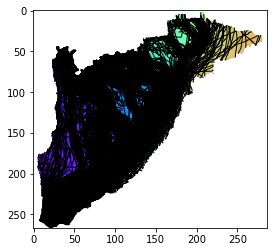

In [23]:
plt.figure()
survey_levels = [0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225]

for rstr_i in range(len(hand_output_raster_list)):        
    #plt.suptitle(rstr_names[rstr_i])
    plt.imshow(wt_crops_ars[rstr_i], wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    plt.contour(wt_crops_ars[rstr_i], survey_levels, colors='k', linewidths=1)
    
    #plt.savefig(os.path.join(figuredirectory, name_raster))
    #plt.close()

## Checking the shapes of rasters

In [24]:
for i in range(len(wt_crops_ars)):
    #print(rstr_names[i])
    #print(wt_crops_ars[i].shape)
    if wt_crops_ars[i].shape == (267, 287):
        pass
    else:
        print("Issue with shape of raster: %s at index: %i" %(rstr_names[i], i))


## Saving all arrays




In [25]:
arrays_location = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\results_arrays'

for i in range(len(wt_crops_ars)):
    print(rstr_names[i])
    arrayfilenm = os.path.join(arrays_location, "%s.out" %rstr_names[i])
    np.savetxt(arrayfilenm, wt_crops_ars[i])


001
002
003
004
005
008
009
012b
012
014
016
017
021
024
025
026
028
029
030
031
032
033
034
036
037
043
044
045
047
048
049
050
AAA3
AGC_001
AGC_011
AGC_014
AGC_015
AGC_016
AGC_018
BARD
BB01
C01
DEW_01
DEW_02
DEW_03
DEW_04
EMM01
E_0123
GH01
J5897
JAR
LW
NB
R01
R051
RS01
SJ01
TV_001
UWA_001
UWA_002
UWA_003
U_1949
XZ01
